# 1. Environment Setup & Imports

Bagian ini bukan hanya memanggil library, tetapi juga memastikan reprodusibilitas (agar hasil training konsisten setiap kali dijalankan).
1. Apa yang dilakukan: Import library, setup device (GPU/CPU), dan seeding.
2. Checklist:
*  Import library utama (Pandas, NumPy, Torch/Tensorflow, Sklearn).
*  Cek ketersediaan GPU (cuda atau mps untuk Mac).
*  PENTING: Set RANDOM_SEED (untuk Python, NumPy, dan Torch/TF) agar hasil eksperimen tidak berubah-ubah.

In [ ]:
# ==========================================
# 1. Environment Setup & Imports
# ==========================================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # Built-in stopwords
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense, Input, Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Memastikan reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


# 2. Configuration (Hyperparameters)

Jangan menyebar angka-angka "ajaib" di seluruh kode. Kumpulkan semua konfigurasi di satu tempat (biasanya menggunakan Class atau Dictionary).
1. Apa yang dilakukan: Menentukan variabel global.
2. Contoh Variabel: BATCH_SIZE = 32, LEARNING_RATE = 2e-5, MAX_LEN = 128, EPOCHS = 5, MODEL_NAME = 'bert-base-uncased'.

In [ ]:
# ==========================================
# 2. Configuration (Hyperparameters)
# ==========================================
# Konfigurasi Data
DATA_PATH = 'IMDB_Dataset.csv'
MAX_NB_WORDS = 50000        # Jumlah kata unik maksimum dalam vocabulary
MAX_SEQUENCE_LENGTH = 250   # Panjang maksimum setiap review (padding/truncating)
EMBEDDING_DIM = 100         # Dimensi vektor embedding
MAX_TOKENS = 20000  # Kosakata
OUTPUT_LEN = 250    # Panjang kalimat (padding otomatis)

# Konfigurasi Training
BATCH_SIZE = 64
EPOCHS = 5
VALIDATION_SPLIT = 0.2

# 3. Data Loading

Memuat data mentah ke dalam memory.
1. Apa yang dilakukan: Membaca file (CSV, JSON, Folder Image).
2. Checklist:
*  Load dataset (misal: pd.read_csv).
*  Tampilkan sampel data (df.head()).
*  Cek missing values (data kosong).

In [ ]:
# ==========================================
# 3. Data Loading
# ==========================================
print("\nLoading Data...")
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(df.head())


Loading Data...
Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# 4. Exploratory Data Analysis (EDA)

Sebelum diolah, data harus dipahami distribusinya.
1. Apa yang dilakukan: Analisis visual dan statistik.
2. Checklist:
*  Cek Class Imbalance (Apakah jumlah Positif vs Negatif seimbang?).
*  Cek panjang teks (Histogram jumlah kata).
*  Cek kualitas data (Apakah banyak tag HTML, typo, atau duplikat?).


Melakukan EDA...
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


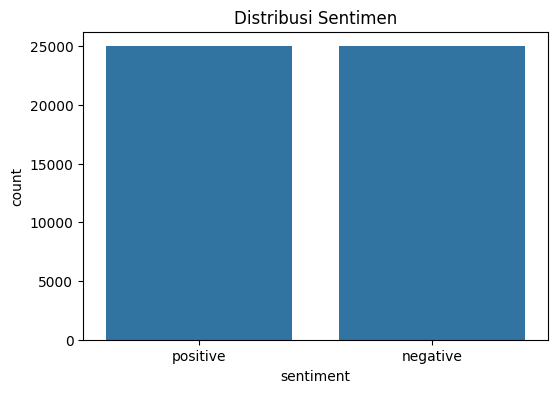



Distribusi Kelas Sentimen:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


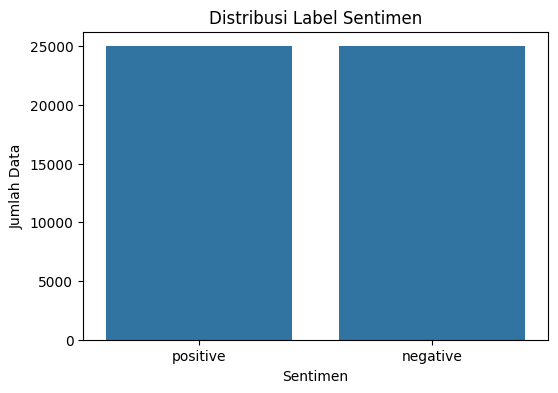



Word Count
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


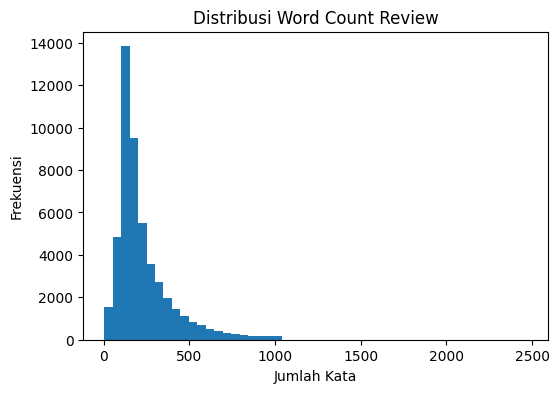



Histogram Fitur Numerik


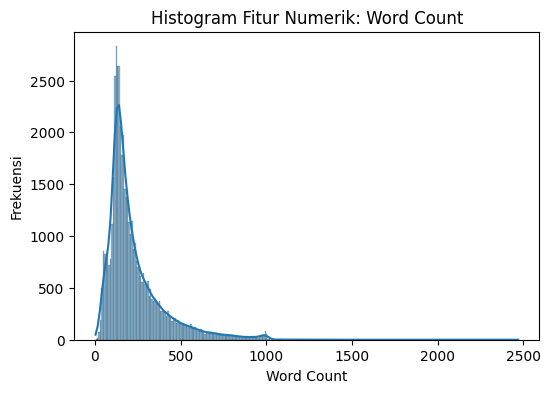



               word_count  sentiment_num
word_count       1.000000       0.009877
sentiment_num    0.009877       1.000000


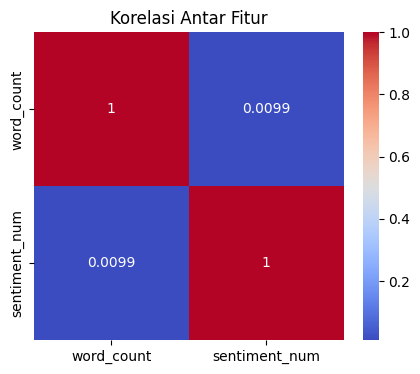



Contoh Sample Data:


,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [ ]:
# ==========================================
# 4. Exploratory Data Analysis (EDA)
# ==========================================
print("\nMelakukan EDA...")
# Cek keseimbangan kelas
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.show()
print('\n')

# Distribusi Label / Kelas
print("Distribusi Kelas Sentimen:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.show()
print('\n')

# Word Count (Histrogram Word Count)
print('Word Count')
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
print(df['word_count'].describe())

plt.figure(figsize=(6, 4))
plt.hist(df['word_count'], bins=50)
plt.title('Distribusi Word Count Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()
print('\n')

# Histogram Fitur Numerik
print('Histogram Fitur Numerik')
plt.figure(figsize=(6, 4))
sns.histplot(df['word_count'], kde=True)
plt.title('Histogram Fitur Numerik: Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frekuensi')
plt.show()
print('\n')

# # Konversi sentiment ke numerik jika masih berupa teks
if df['sentiment'].dtype == 'object':
    df['sentiment_num'] = df['sentiment'].map({'negative': 0, 'positive': 1})
else:
    df['sentiment_num'] = df['sentiment']

# Korelasi
corr_matrix = df[['word_count', 'sentiment_num']].corr()
print(corr_matrix)

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()
print('\n')

print("Contoh Sample Data:")
df[['review', 'sentiment']].sample(5, random_state=42)

# 5. Text Preprocessing (Cleaning)

Membersihkan data mentah menjadi data yang siap dimakan mesin.
1. Apa yang dilakukan: Pembersihan string.
2. Checklist:
*  Lowercasing (huruf kecil semua).
*  Menghapus Noise (Tag HTML <br>, URL, Emoji, Tanda baca berlebih).
*  Menghapus Stopwords (opsional, hati-hati jika menggunakan BERT, kadang stopwords dibutuhkan untuk konteks).

In [ ]:
# ==========================================
# 5. Text Preprocessing (Cleaning)
# ==========================================
# Menggunakan set stopwords dari sklearn agar efisien
stopwords = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    """
    Membersihkan teks dari tag HTML, URL, karakter non-alfabet, dan stopwords.
    """
    # 1. Lowercase
    text = text.lower()
    # 2. Hapus HTML tags (<br />, dsb)
    text = re.sub(r'<br\s*/?>', ' ', text)
    # 3. Hapus URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # 4. Hapus karakter khusus (simpan hanya huruf dan spasi)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 5. Hapus Stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])

    return text

print("\nMembersihkan teks (ini mungkin memakan waktu)...")
df['clean_review'] = df['review'].apply(clean_text)

# Mapping label: positive -> 1, negative -> 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Penanganan Missing Value
print("\nMenghapus data dengan missing value...")
df = df.dropna(subset=['clean_review', 'sentiment'])

#  Mapping Label
# positive -> 1, negative -> 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Word Count (opsional, untuk EDA / analisis)
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

# Pembagian Data (Train / Validation / Test)
X = df['clean_review']
y = df['label']

# 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("\nJumlah Data:")
print(f"Train      : {len(X_train)}")
print(f"Validation : {len(X_val)}")
print(f"Test       : {len(X_test)}")


Membersihkan teks (ini mungkin memakan waktu)...

Menghapus data dengan missing value...

Jumlah Data:
Train      : 35000
Validation : 7500
Test       : 7500


# 6. Data Splitting

Membagi data sebelum tokenisasi untuk mencegah Data Leakage.
1. Apa yang dilakukan: Membagi dataset menjadi 3 bagian.
2. Standar:
*  Train Set (70-80%): Untuk melatih model.
*  Validation Set (10-15%): Untuk evaluasi saat training (tuning hyperparameter).
*  Test Set (10-15%): Untuk evaluasi akhir (data yang benar-benar belum pernah dilihat model).

In [ ]:
# ==========================================
# 6. Data Splitting
# ==========================================
# Kita split data mentah dulu sebelum tokenisasi untuk simulasi real-world
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_review'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\nTrain set: {X_train_text.shape}")
print(f"Test set: {X_test_text.shape}")


Train set: (40000,)
Test set: (10000,)


# 7. Tokenization & Dataset Class

Mengubah teks menjadi angka.
1. Apa yang dilakukan: Konversi teks ke format Tensor.
2. Checklist:
*  Tokenizer: Mengubah kalimat menjadi urutan ID angka.
*  Padding/Truncation: Menyamakan panjang kalimat.
*  Custom Dataset Class (Pytorch): Membuat class yang mewarisi torch.utils.data.Dataset.
*  DataLoaders: Membuat iterator yang memecah data menjadi Batch.

In [ ]:
# ==========================================
# 7. Tokenization & Dataset Class
# ==========================================
print("\nTokenisasi...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text) # Fit hanya pada training data!

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Mengubah teks menjadi urutan angka (sequences)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Padding agar panjang sequence seragam
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

print("Shape of data tensor:", X_train_pad.shape)


Tokenisasi...
Found 142654 unique tokens.
Shape of data tensor: (40000, 250)


# 8. Model Architecture

Mendefinisikan otak dari AI.
1. Apa yang dilakukan: Membuat Class Neural Network.
2. Checklist:
*  Definisi Layer (Embedding, LSTM/BERT, Dropout, Linear/Dense).
*  Definisi forward pass (alur data mengalir dari input ke output).

In [ ]:
# ==========================================
# 8. Model Architecture
# ==========================================
print("\nMembangun Model Bi-LSTM...")
model = Sequential()

# Layer 1: Embedding (Belajar representasi vektor dari nol)
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH))

# Layer 2: SpatialDropout1D (Mencegah overfitting pada embedding)
model.add(SpatialDropout1D(0.2))

# Layer 3: Bidirectional LSTM
# Bidirectional memungkinkan model belajar konteks dari masa lalu dan masa depan
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
# Catatan: recurrent_dropout membuat training lebih lambat (matikan jika pakai cuDNN LSTM)

# Layer 4: Dense Layer dengan ReLU
model.add(Dense(32, activation='relu'))

# Layer 5: Output Layer (Sigmoid untuk binary classification)
model.add(Dense(1, activation='sigmoid'))

model.summary()


Membangun Model Bi-LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# 9. Training Setup

Menyiapkan "guru" dan "aturan penilaian".
1. Checklist:
*  Loss Function: Misal BinaryCrossEntropy (untuk klasifikasi 2 kelas).
*  Optimizer: Misal AdamW (standar emas saat ini).
*  Scheduler: Untuk menurunkan learning rate secara perlahan (opsional tapi disarankan).

In [ ]:
# ==========================================
# 9. Training Setup
# ==========================================
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# EarlyStopping: Berhenti jika validasi loss tidak membaik selama 'patience' epoch
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True,
                           verbose=1)

# 10. Training & Validation Loop

Jantung dari proses pembelajaran.
1. Apa yang dilakukan: Melakukan iterasi per epoch.
2. Struktur Loop:
*  Model set ke mode train().
*  Hitung prediksi -> Hitung Loss -> Backpropagation -> Update bobot.
*  Model set ke mode eval().
*  Hitung performa di Validation Set.
*  Simpan model jika performa validation membaik (Model Checkpointing).

In [ ]:
# ==========================================
# 10. Training & Validation Loop
# ==========================================
print("\nMulai Training...")
history = model.fit(X_train_pad, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stop],
                    verbose=1)

# Simpan Model
model.save('model_bilstm.h5') # Format H5 lama
model.save('model_bilstm.keras') # Format Keras baru (opsional)
print("Model berhasil disimpan.")

print("Menyimpan Tokenizer...")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer berhasil disimpan sebagai 'tokenizer.pickle'")


Mulai Training...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 434s 682ms/step - accuracy: 0.7570 - loss: 0.4768 - val_accuracy: 0.8904 - val_loss: 0.2736
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 452s 723ms/step - accuracy: 0.9118 - loss: 0.2357 - val_accuracy: 0.8880 - val_loss: 0.3012
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 428s 685ms/step - accuracy: 0.9421 - loss: 0.1625 - val_accuracy: 0.8827 - val_loss: 0.3583
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 459s 733ms/step - accuracy: 0.9608 - loss: 0.1110 - val_accuracy: 0.8804 - val_loss: 0.3941
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Model berhasil disimpan.
Menyimpan Tokenizer...
Tokenizer berhasil disimpan sebagai 'tokenizer.pickle'


# 11. Evaluation (Testing)

Menguji model "Juara" di Test Set.
1. Apa yang dilakukan: Mengukur performa objektif.
2. Checklist:
*  Hitung Akurasi, Precision, Recall, F1-Score.
*  Tampilkan Confusion Matrix (untuk melihat di mana model sering salah).
*  Plot kurva Training Loss vs Validation Loss (untuk cek Overfitting).

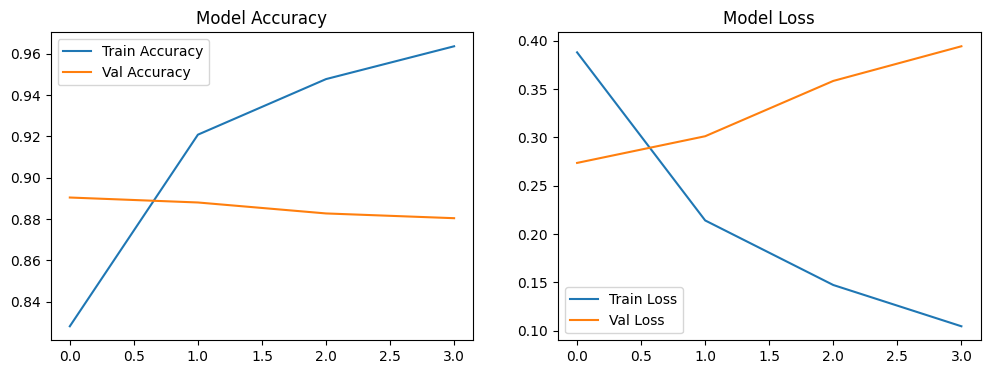


Evaluasi pada Test Set:
Test Accuracy: 89.04%
Test Loss: 0.2736
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      5000
           1       0.88      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# ==========================================
# 11. Evaluation (Testing)
# ==========================================
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Evaluasi pada Test Set
print("\nEvaluasi pada Test Set:")
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Loss: {loss:.4f}')

# Confusion Matrix & Classification Report
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 12. Inference (Prediction)

Fungsi untuk penggunaan dunia nyata.
1. Apa yang dilakukan: Tes manual dengan input baru.
2. Checklist:
*  Buat fungsi predict_sentiment(text).
*  Terima input string mentah -> Preprocess -> Model -> Output label (Positif/Negatif).

In [ ]:
# ==========================================
# 12. Inference (Prediction)
# ==========================================
def predict_sentiment(text):
    # 1. Clean
    cleaned_text = clean_text(text)
    # 2. Tokenize & Pad
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    # 3. Predict
    pred_prob = model.predict(padded)[0][0]

    label = "Positive" if pred_prob > 0.5 else "Negative"
    return label, pred_prob

# Contoh Penggunaan
new_review = "The movie was absolutely fantastic! Great acting and story."
label, confidence = predict_sentiment(new_review)
print(f"\nReview: {new_review}")
print(f"Prediction: {label} ({confidence:.4f})")

bad_review = "Total waste of time. The plot was boring and predictable."
label_bad, confidence_bad = predict_sentiment(bad_review)
print(f"\nReview: {bad_review}")
print(f"Prediction: {label_bad} ({confidence_bad:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Review: The movie was absolutely fantastic! Great acting and story.
Prediction: Positive (0.8524)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

Review: Total waste of time. The plot was boring and predictable.
Prediction: Negative (0.0208)
